In [1]:
import torch
import matplotlib.pyplot as plt
from dem.energies.lennardjones_energy import LennardJonesEnergy

/storage/scratch1/e17-kadsap-diffusion-models/miniconda3/envs/dem/lib/python3.10/site-packages/torchmetrics/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
# Paths
train_path = "data/train_split_LJ13-1000.npy"
generated_path = "LJ13_efm/samples_1_100000.pt"

# Initialize LJ13 energy function
lj13 = LennardJonesEnergy(
    dimensionality=39,  # 13 particles x 3D
    n_particles=13,
    data_path=train_path,
    data_path_train=train_path,
    data_path_val=train_path,
    data_path_test=train_path,  # required for test set
    device="cpu",
)

In [3]:
def remove_mean(samples, n_particles, n_dimensions):
    """Makes a configuration of many particle system mean-free.

    Parameters
    ----------
    samples : torch.Tensor
        Positions of n_particles in n_dimensions.

    Returns
    -------
    samples : torch.Tensor
        Mean-free positions of n_particles in n_dimensions.
    """
    shape = samples.shape
    if isinstance(samples, torch.Tensor):
        samples = samples.view(-1, n_particles, n_dimensions)
        samples = samples - torch.mean(samples, dim=1, keepdim=True)
        samples = samples.view(*shape)
    else:
        samples = samples.reshape(-1, n_particles, n_dimensions)
        samples = samples - samples.mean(axis=1, keepdims=True)
        samples = samples.reshape(*shape)
    return samples

In [4]:
# Load samples
train_samples = lj13.setup_train_set()
generated_samples = torch.load(generated_path).cpu()

# Remove mean for consistency
train_samples = remove_mean(train_samples, 13, 3)
generated_samples = remove_mean(generated_samples, 13, 3)


# Compute interatomic distances
dist_train = lj13.interatomic_dist(train_samples).detach().cpu()
dist_generated = lj13.interatomic_dist(generated_samples).detach().cpu()

# Compute energies
energy_train = -lj13(train_samples).detach().cpu()
energy_generated = -lj13(generated_samples).detach().cpu()

/tmp/ipykernel_2707907/3596663622.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generated_samples = torch.load(generated_path).cpu()


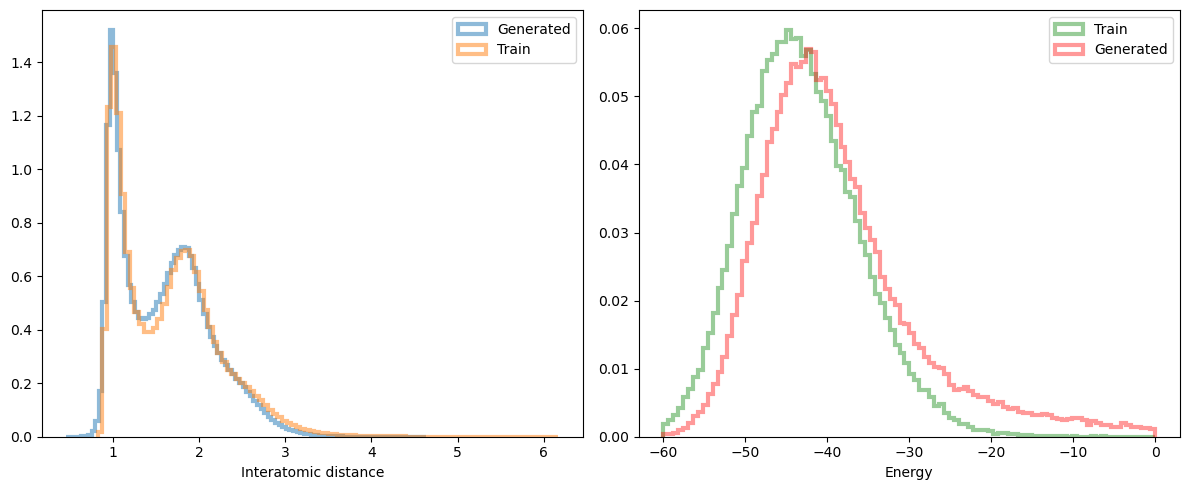

In [5]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Interatomic distance histogram
axs[0].hist(dist_generated.view(-1), bins=100, alpha=0.5, density=True, histtype="step", linewidth=3)
axs[0].hist(dist_train.view(-1), bins=100, alpha=0.5, density=True, histtype="step", linewidth=3)
axs[0].set_xlabel("Interatomic distance")
axs[0].legend(["Generated", "Train"])

# Energy histogram
min_energy, max_energy = -60, 0  # for LJ13
axs[1].hist(energy_train, bins=100, density=True, range=(-60, 0), alpha=0.4, color="g", histtype="step", linewidth=3, label="Train")
axs[1].hist(energy_generated, bins=100, density=True, range=(-60, 0),alpha=0.4, color="r", histtype="step", linewidth=3, label="Generated")
axs[1].set_xlabel("Energy")
axs[1].legend()

plt.tight_layout()
plt.show()